# 3D Structure Prediction of Nanoporous Carbons via Gas Adsorption

In [202]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
from scipy.optimize import nnls

In [225]:
#Structures available in the kernel
structures = 89
#Structures that are calculated with atomistic model (not through Kelvin equation)
structures_model = 78

In [257]:
#Excel filename with the kernel data
excel_database = r'kernel.xlsx'

#Load structural parameters into a Pandas dataframe
df_structures = pd.read_excel(excel_database,
                   sheet_name='Details',
                   header=1,
                   nrows=structures,
                   index_col=1,
                   engine='openpyxl')

#Load calculated adsorption isotherms into a dataframe
df_isotherm = pd.read_excel(excel_database,
                   sheet_name='N2 77 K 1CLJ',
                   header=None,
                   skiprows=8,
                   nrows=64,
                   usecols='A:CL',
                   engine='openpyxl')

#These are structures with low density that did not form a solid framework.
#By making their isotherms equal to zero, they are removed from the regression
df_isotherm[9] = 0
df_isotherm[13] = 0

#Read pore size distributions and load into dataframe
df_PSD_pb = pd.read_excel(excel_database,
                   sheet_name='Poreblazer PSDs_2', #_2 for ultranarrow pores ~1 A
                   header=None,
                   skiprows=6,
                   nrows=210,
                   usecols='A:CL',
                   engine='openpyxl')
#Convert pore size distribution data to a numpy array
np_PSD_pb = np.array(df_PSD_pb)[:,1:]

In [258]:
#Remove some initial experimental points where the experimental data is usually flawed
points_to_remove = 12 #for pg_600_new
points_to_remove = 13 #for a20_lao
points_to_remove = 17 #for cdc-400-600
#points_to_remove = 18 #for yp50f_lao
points_to_remove = 18 #for c211417 (Ingevity)
points_to_remove = 23 #for c211417 (Ingevity)
points_to_remove = 0 #for CNH_uri

np_isotherm = np.array(df_isotherm)[points_to_remove:,1:]
np_pressure_gcmc = np.array(df_isotherm)[points_to_remove:,0]

In [259]:
#load experimental isotherm
#It must be a tab-separated file with two columns.
#First column is relative pressure and second column adsorbed volume in units cc STP/g
experimental_isotherm_file = 'pg600_new.tsv'
experimental_isotherm_file = 'a20_lao.tsv'
experimental_isotherm_file = 'cdc-400-600.tsv'
#experimental_isotherm_file = 'yp50f_lao.tsv'
#experimental_isotherm_file = 'CNB2.tsv'
experimental_isotherm_file = 'C211417.tsv'
experimental_isotherm_file = 'C230244.tsv'
experimental_isotherm_file = 'CNH_uri.tsv'

exp_iso = np.genfromtxt (experimental_isotherm_file, delimiter="\t") #load isotherm file into numpy array
exp_iso_interp = np.interp(np_pressure_gcmc, exp_iso[:,0], exp_iso[:,1]) #interpolate isotherm to points of the kernel

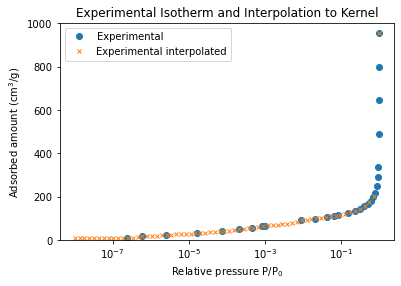

In [260]:
plt.plot(exp_iso[:,0], exp_iso[:,1],label='Experimental', marker='o', linestyle='none')
plt.xlabel("Relative pressure P/P$_0$")
plt.ylabel("Adsorbed amount (cm$^3$/g)")
plt.ylim(bottom=0)  # adjust the bottom leaving top unchanged
plt.plot(np_pressure_gcmc, exp_iso_interp,
         label='Experimental interpolated',
         marker='x',
         markersize=4,
         linestyle='none')
plt.xscale('log')
plt.title('Experimental Isotherm and Interpolation to Kernel')
plt.legend()
plt.show()

In [261]:
#Use non-negative least squares to find the coefficients that fit the experimental isotherm from the kernel isotherms
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html
solution, residual = nnls(np_isotherm, exp_iso_interp)

print(f"Residual total= {residual:.3f} cc/g") #norm of residuals = sqrt of sum (error^2)
print(f"Residual per point = {residual/np_pressure_gcmc.size:.3f} cc/g") #norm of residuals = sqrt of sum (error^2)

Residual total= 12.272 cc/g
Residual per point = 0.192 cc/g


In [262]:
def calculate_isotherm(solution):
    # This function sums the contributions of every kernel structure
    # in order to calculate the predicted isotherm.
    isotherm = np.zeros(np_pressure_gcmc.size) #create an empty vector
    for i in range(structures):
        isotherm = isotherm + solution[i] * np.array(np_isotherm[:,i])
    return isotherm

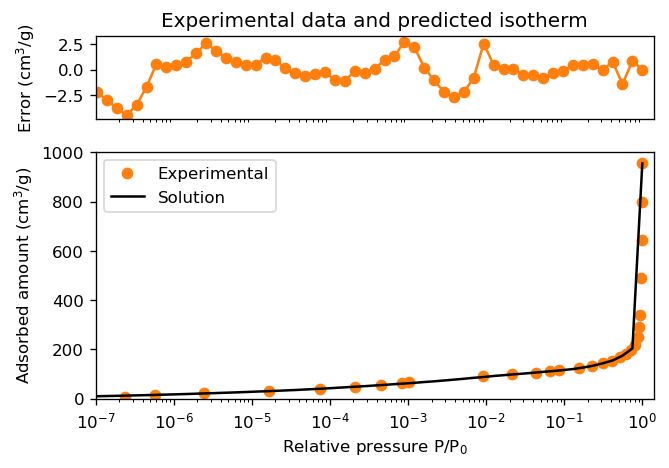

In [263]:
# Plot experimental datapoints and show the fit
log_scale_plot = True #use True if you want to plot using logarithmic scale in x
fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [1, 3]}, dpi=120) #, figsize=(3,3)

# Top plot for error
ax[0].set_title('Experimental data and predicted isotherm')
ax[0].plot(np_pressure_gcmc, exp_iso_interp-calculate_isotherm(solution), marker='o', linestyle='solid', color='tab:orange')
if log_scale_plot:
    ax[0].set_xscale('log')
ax[0].set_ylabel("Error (cm$^3$/g)")
#ax[0].set_ylabel("Error")
if log_scale_plot:
    ax[0].set_xlim(left=1e-7, right=1.4)
else:
    ax[0].set_xlim(left=-0.02, right=1)

ax[0].axes.get_xaxis().set_ticks([])
#ax[0].axes.get_yaxis().set_ticks([])

# Bottom plot of isotherm and fitted isotherm
ax[1].plot(exp_iso[:,0], exp_iso[:,1],
           label='Experimental',
           marker='o',
           linestyle='none',
           color='tab:orange')
ax[1].plot(np_pressure_gcmc, calculate_isotherm(solution),
           label='Solution',
           linestyle='solid',
           color='black')
if log_scale_plot:
    ax[1].set_xscale('log')
ax[1].set_xlabel("Relative pressure P/P$_0$")
#ax[1].set_xlabel("P/P$_0$")
ax[1].set_ylabel("Adsorbed amount (cm$^3$/g)")
#ax[1].set_ylabel("Adsorption")
ax[1].legend()
ax[1].set_ylim(bottom=0)
if log_scale_plot:
    ax[1].set_xlim(left=1e-7, right=1.4)
else:
    ax[1].set_xlim(left=-0.02, right=1)
#if log_scale_plot:
#    ax[1].set_xlim(left=1e-7, right=1.4)
#ax[1].axes.get_yaxis().set_ticks([])
plt.ylim(bottom=0)
plt.show()

In [264]:
#Export interpolated isotherm, solution and error to file
if False:
    np.savetxt("export_isotherm.tsv",
               np.array([np_pressure_gcmc,
                         exp_iso_interp,
                         calculate_isotherm(solution),
                         exp_iso_interp-calculate_isotherm(solution)]).T,
               delimiter='\t',
               header=f"P/P0\tInterpolated isotherm (cc STP/g)\tSolution isotherm (cc STP/g)\tError (cc STP/g)",
               comments="")

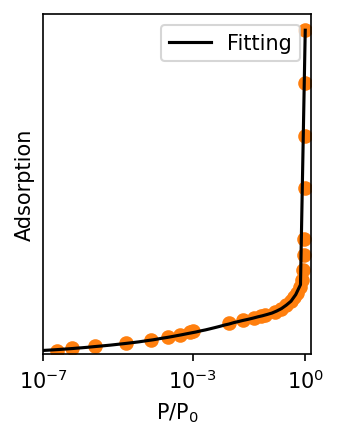

In [265]:
# Plot experimental datapoints and show the fit
fig, ax = plt.subplots(dpi=150, figsize=(2.3,3))

#fig.patch.set_facecolor('orange')
fig.patch.set_alpha(0)

# Bottom plot of isotherm and fitted isotherm
ax.plot(exp_iso[:,0], exp_iso[:,1],
           #label='Experimental',
           marker='o',
           linestyle='none',
           color='tab:orange')
ax.plot(np_pressure_gcmc, calculate_isotherm(solution),
           label='Fitting',
           linestyle='solid',
           color='black')
ax.set_xscale('log')
#ax.set_xlabel("Relative pressure P/P$_0$")
ax.set_xlabel("P/P$_0$")
#ax.set_ylabel("Adsorbed amount (cm$^3$/g)")
ax.set_ylabel("Adsorption")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=1e-7, right=1.4)
ax.axes.get_yaxis().set_ticks([])
ax.axes.get_xaxis().set_ticks([1e-7, 1e-3, 1])
plt.ylim(bottom=0)
plt.show()

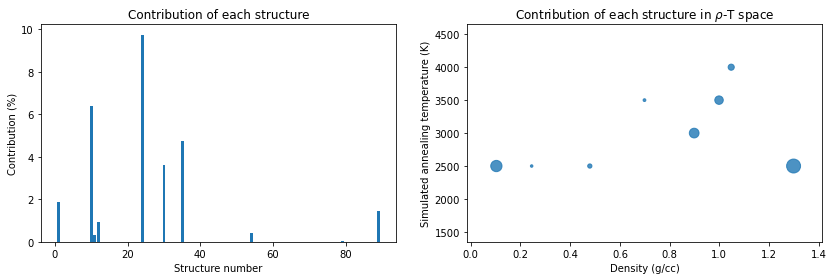

In [274]:
#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].bar(range(1, structures+1), solution*100)
ax[0].set_xlabel("Structure number")
ax[0].set_ylabel("Contribution (%)")
ax[0].set_title('Contribution of each structure')

#Density-Temperature space plot
ax[1].scatter(df_structures['System density, g/cm^3'][:structures_model],
              df_structures['T(K)'][:structures_model],
              s=solution[:structures_model]*2000,
              alpha=0.8)
ax[1].set_xlabel('Density (g/cc)')
ax[1].set_ylabel('Simulated annealing temperature (K)')
ax[1].set_title(r'Contribution of each structure in $\rho$-T space')

plt.show()

In [215]:
# Show top contributions
top_n = 15
for i in range(top_n):
# Use this if all the range is desired: for i in range(structures):
    struct = np.argsort(solution)[::-1][i]
    print(f"Structure #{struct+1}:\t{solution[struct]*100:0.3f}%")

Structure #24:	9.748%
Structure #10:	6.370%
Structure #35:	4.735%
Structure #30:	3.612%
Structure #1:	1.896%
Structure #89:	1.431%
Structure #12:	0.910%
Structure #54:	0.391%
Structure #11:	0.323%
Structure #79:	0.042%
Structure #83:	0.000%
Structure #86:	0.000%
Structure #25:	0.000%
Structure #26:	0.000%
Structure #27:	0.000%


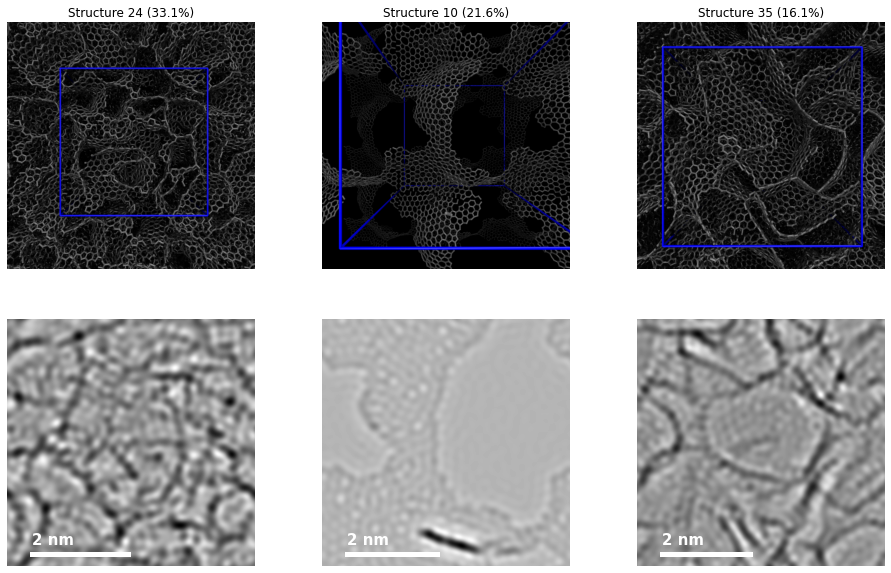

In [216]:
# Create a figure of a render and simulated TEM with the top contributors
fig, ax = plt.subplots(2,3, figsize=(16,10))
for i in range(3):
    structure_render = np.argsort(solution)[-1-i]+1
    file_render = f'rendered structures/{structure_render:03d}.png'
    render = img.imread(file_render)
    ax[0,i].set_axis_off()
    ax[0,i].imshow(render)
    ax[0,i].title.set_text(f'Structure {structure_render:02d} ({(solution[structure_render-1])/sum(solution)*100:.1f}%)')

    file_render = f'simulated TEM/{structure_render:02d}.tif'
    render = img.imread(file_render)
    ax[1,i].set_axis_off()
    ax[1,i].imshow(render, cmap='gist_gray')

    with open (f'structures/{structure_render:03d}.xyz') as fh:
        next(fh)
        lattice_size = float(next(fh).split(" ")[0])
    bar_length_pixels = 20*render.shape[0]/lattice_size
    pixels_sim_tem = render.shape[0]
    ax[1,i].text(50,
                 pixels_sim_tem*0.91,
                 "2 nm",
                 color='white',
                 fontsize=15,
                 fontweight='bold')
    ax[1,i].plot([50, 50+bar_length_pixels],
                 [pixels_sim_tem*0.95, pixels_sim_tem*0.95],
                 '-',
                 lw=5,
                 color='white')

In [217]:
print(f"Sum of solution = {sum(solution):.3f}", end="\n")
print(f"Density g/cc = {sum(df_structures[' System density, g/cm^3']*solution):.4f}")
print(f"He volume cc/g = {sum(df_structures[' Helium volume in cm^3/g']*solution):.4f}")
print(f"Geometric (point accessible) volume in cm^3/g = {sum(df_structures[' Geometric (point accessible) volume in cm^3/g']*solution):.4f}")
#print(f"Probe-occupiable volume cc/g = {sum(df_structures['V PO cm3/g']*solution):.4f}")
#print(f"Accessible area m2/g = {int(sum(df_structures[' Accessible surface area per mass in m^2/g']*solution)):d}")
print(f"Total area m2/g = {int(sum(df_structures['Total surface area m^2/g']*solution)):d}")

simulation_temperature = sum(df_structures['T(K)']*solution/sum(solution))
print("Simulation temperature (K) = {simulation_temperature:.0f}")
time_sim = 2e-9 #2 nanoseconds in seconds
kB = 8.617e-5 #eV/K
activ_energy = 6 #eV
temp_exp = 1/simulation_temperature - kB / activ_energy * np.log(time_sim/3600)
temp_exp = 1/temp_exp
print(f"Equivalent graphitization temperature (K) = {temp_exp:.0f}")

Sum of solution = 0.295
Density g/cc = 0.2396
He volume cc/g = 0.7829
Geometric (point accessible) volume in cm^3/g = 1.4723
Total area m2/g = 497
Simulation temperature (K) = {simulation_temperature:.0f}
Equivalent graphitization temperature (K) = 1286


In [218]:
def PascalTriangle(n):
    # This calculates a Pascal triangle that will be used for smoothing
    # https://www.askpython.com/python/examples/pascals-triangle-using-python
    # https://danielmuellerkomorowska.com/2020/06/02/smoothing-data-by-rolling-average-with-numpy/
    trow = [1]
    y = [0]
    for x in range(n):
        trow=[left+right for left,right in zip(trow+y, y+trow)]
    return trow


# Calculate PSD
PSD_weighted = np_PSD_pb
PSD_solution = (np.array(df_structures[' Helium volume in cm^3/g']) * solution * PSD_weighted).sum(axis=1)

#Smooth the PSD
smooth_kernel_size = 70 # Increase this for smoother results
smooth_kernel = np.array(PascalTriangle(smooth_kernel_size))
smooth_kernel = smooth_kernel / smooth_kernel.sum()
PSD_solution_smooth = np.convolve(PSD_solution, smooth_kernel, mode='same')

PSD_solution_smooth[0:3] = np.nan

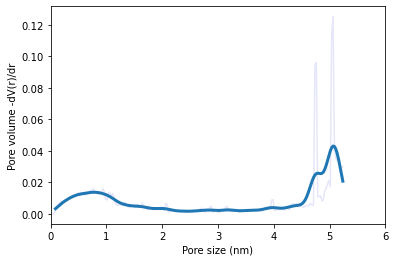

In [219]:
# Plot PSD
fig, ax = plt.subplots()

plt.plot(df_PSD_pb[0]/10, PSD_solution, color='lavender') # Use light color for original PSD solution
plt.plot(df_PSD_pb[0]/10, PSD_solution_smooth, linewidth=3) # Heavier color for smoothed solution
plt.xlim([0,6])
plt.xlabel("Pore size (nm)")
#plt.xlabel("Pore size")
plt.ylabel("Pore volume -dV(r)/dr")
#plt.ylabel("Pore volume")
#plt.title("Pore size distribution")
plt.show()

In [222]:
#Export PSD to file
if False:
    np.savetxt("export_PSD_cdc-400-600.tsv",
               np.array([df_PSD_pb[0]/10,
                         PSD_solution/10,
                         PSD_solution_smooth/10]).T,
               delimiter='\t',
               header=f"Pore size (A)\tPSD\tSmoothed PSD",
               comments="")

In [223]:
# Print the resulting pore size distribution
for i in range(df_PSD_pb[0].size):
    print(df_PSD_pb[0][i], PSD_solution_smooth[i])

0.125 nan
0.375 nan
0.625 nan
0.875 0.0032997594952402683
1.125 0.004053788026092155
1.375 0.004831139990466122
1.625 0.005604776074179322
1.875 0.006352893821727124
2.125 0.0070613741492949415
2.375 0.007724090235698376
2.625 0.008341294676842899
2.875 0.008916869981065669
3.125 0.0094554417483881
3.375 0.009960187081756689
3.625 0.010431765457694689
3.875 0.010868370872256625
4.125 0.011266620633177961
4.375 0.011622903887220723
4.625 0.011934844453370307
4.875 0.012202581932420494
5.125 0.012429584964762317
5.375 0.012622712275118282
5.625 0.012791319504384991
5.875 0.012945438206555861
6.125 0.01309339584675002
6.375 0.013239559995284367
6.625 0.01338299032351796
6.875 0.013517552299912142
7.125 0.013633532098610662
7.375 0.01372020629740973
7.625 0.01376844496502369
7.875 0.013772458421019278
8.125 0.01373022271539401
8.375 0.013642708206140058
8.625 0.013512474373499275
8.875 0.01334227163317124
9.125 0.013134032654600416
9.375 0.012888279435448327
9.625 0.012603796985423958
9.87